In [1]:
import pickle
import pandas as pd
import numpy as np
import json
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
from tqdm import tqdm
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [2]:
import pandas as pd
import numpy as np
import re
from re import sub
import multiprocessing
import seaborn as sns
import nltk
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from sklearn.cluster import KMeans

from time import time 
from collections import defaultdict

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
# #file_to_read = open("twm_store_reviews.pickle", "rb")
# df1 = pd.read_csv('fulldata_TWM_review.csv')

# #file_to_read = open("twm_store_reviews11-20_55-79.pickle", "rb")
# df2 = pd.read_csv('review_21_55.csv')
# df2=df2[['Product name', 'Reviews', 'Reviews_title']]
# # df2=pd.read_csv('data_combined.csv')
# df=pd.concat([df1,df2])
# df.to_csv('final_data_TWM_review.csv', index=False)

In [4]:
df=pd.read_csv('final_data_TWM_review.csv')

In [5]:
df=df.replace('',np.nan)

In [6]:
df=df.dropna(subset=['Reviews','Reviews_title'],how='all').reset_index(drop=True)

In [7]:
df

,Product name,Reviews,Reviews_title
0,Lonehand Whiskey 1.75l,I thought I’d give this a try as a cheap mixin...,Do Not Buy This!
1,Lonehand Whiskey 1.75l,I have enjoyed this for several months now,Very Smooth
2,Lonehand Whiskey 1.75l,I love Lonehand Wiskey. It's one of my favorit...,Lonehand Wiskey
3,Lonehand Whiskey 1.75l,NaN,Tasty
4,Lonehand Whiskey 1.75l,It has a nice smooth back end with a hint of v...,Lone Hand
...,...,...,...
65804,Ole Smoky Tennessee Moonshine Blue Flame 750ml,God awful. Might as well drink cleaning suppli...,Awful
65805,Ole Smoky Tennessee Moonshine Blue Flame 750ml,Will haunt your dreams and draw a tear- or mor...,Dirty Cancerous Sock
65806,Ole Smoky Tennessee Moonshine Blue Flame 750ml,I love the Ole Smoky clear and with peaches!!I...,It'S Strong
65807,Ole Smoky Tennessee Moonshine Blue Flame 750ml,I and my wife enjoy this with a juice or a bot...,Good For Mixing


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65809 entries, 0 to 65808
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product name   65809 non-null  object
 1   Reviews        62075 non-null  object
 2   Reviews_title  59302 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


In [9]:
df.isnull().sum()

Product name        0
Reviews          3734
Reviews_title    6507
dtype: int64

In [10]:
for i in range(df.shape[0]):
    try:
        blob = TextBlob(df.iloc[i,1])
        if(blob.sentiment.polarity!=0):
            df.loc[i,'Review_sentiment']=blob.sentiment.polarity
        else:
            df.loc[i,'Review_sentiment']=np.nan
    except:
        df.loc[i,'Review_sentiment']=np.nan
        
    try:
        blob = TextBlob(df.iloc[i,2])
        if(blob.sentiment.polarity!=0):
            df.loc[i,'Review_title_sentiment']=blob.sentiment.polarity
        else:
            df.loc[i,'Review_title_sentiment']=np.nan
    except:
        df.loc[i,'Review_title_sentiment']=np.nan

In [11]:
df['Review_sentiment'].fillna(df['Review_title_sentiment'], inplace=True)
df['Review_title_sentiment'].fillna(df['Review_sentiment'], inplace=True)

In [12]:
df[df['Review_sentiment'].isnull()]['Review_title_sentiment'].isnull().sum()

3263

In [13]:
for i in range(df.shape[0]):
    try:
        rs = abs(df.iloc[i,3])
        rst=abs(df.iloc[i,4])
        if(rs>=rst):
            df.loc[i,'Final_sentiment']=df.iloc[i,3]
        else:
            df.loc[i,'Final_sentiment']=df.iloc[i,4]
    except:
        df.loc[i,'Final_sentiment']=np.nan

In [14]:
# neg=df[(df['Review_sentiment']<0) | (df['Review_title_sentiment']<0)]
# neg.groupby('Product name').mean()

In [15]:
df['signed_Final_sentiment']=np.sign(df['Final_sentiment'])


In [16]:
df_rev=df.dropna(subset=['Reviews_title'])

pos_reviews_combined=df_rev[df_rev['Final_sentiment']>0].groupby(['Product name'])[['Reviews_title']].agg(lambda x: ' '.join(x)).reset_index()
neg_reviews_combined=df_rev[df_rev['Final_sentiment']<0].groupby(['Product name'])[['Reviews_title']].agg(lambda x: ' '.join(x)).reset_index()



In [17]:
comb_reviews=pd.merge(pos_reviews_combined,neg_reviews_combined,on='Product name',how='outer')
comb_reviews.columns=['Product name', 'Positive_Reviews', 'Negative_Reviews']

In [18]:
comb_reviews['Positive_Reviews'].fillna('', inplace=True)
comb_reviews['Negative_Reviews'].fillna('', inplace=True)


In [19]:
comb_reviews['review_combined']=comb_reviews['Positive_Reviews']+comb_reviews['Negative_Reviews']

In [20]:
comb_reviews

,Product name,Positive_Reviews,Negative_Reviews,review_combined
0,10th Street Peated Single Malt Distillers Cut ...,Grain To Glass Craft From San Jose! Good Produ...,,Grain To Glass Craft From San Jose! Good Produ...
1,10th Street Single Malt American Whiskey 750ml,Definitely In My Regular Rotation Excellent Am...,,Definitely In My Regular Rotation Excellent Am...
2,10th Street Unpeated STR Sngle Mlt 750ml,My New Favorite!,,My New Favorite!
3,1792 Bourbon 1.75l,Outstanding For The Price. Solid Value Great T...,Small Batch Find Overrated Blind Taste Test Ve...,Outstanding For The Price. Solid Value Great T...
4,1792 Full Proof Bourbon 750ml,Great Value - Very Approachable Jim Murray Is ...,"Undrinkable Horrible, Impossible To Drink Stra...",Great Value - Very Approachable Jim Murray Is ...
...,...,...,...,...
1455,Ohishi Islay Cask Finish Whisky Barrel Select ...,,All Warmth No Burn...Well Made,All Warmth No Burn...Well Made
1456,Shimauta 5 Yr Ryukyu Japanese Whisky 750ml,,Big Yikes,Big Yikes
1457,St George Rye Gin Reposado 750ml,,"I Usually Like St. George Stuff, But Not This One","I Usually Like St. George Stuff, But Not This One"
1458,The Shinobu Blended Whisky Mizunara Oak 750ml,,Just Bad,Just Bad


### Word embeddings:

In [21]:
import tensorflow_hub as hub

In [22]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

INFO - 12:54:35: Using /var/folders/88/tzwxzp8j30gb2wb_wpr89_kr0000gn/T/tfhub_modules to cache modules.
INFO - 12:54:35: Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO - 12:54:53: Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 40.00MB
INFO - 12:55:08: Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 210.00MB
INFO - 12:55:23: Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 440.00MB
INFO - 12:55:38: Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 680.00MB
INFO - 12:55:54: Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 920.00MB
INFO - 12:55:58: Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO - 12:55:58: Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [23]:
sentence_embeddings = model(comb_reviews['review_combined'])

In [761]:
#pd.DataFrame(sentence_embeddings.numpy())

In [805]:
comb_reviews=pd.merge(comb_reviews,pd.DataFrame(sentence_embeddings.numpy()), on=comb_reviews.index).drop('key_0', axis=1)

In [806]:
d = {'Final_sentiment':'Final_sentiment', 'Reviews':'Review count'}
rec=df.groupby('Product name').agg({'Final_sentiment':'mean', 'Reviews':'count'}).rename(columns=d)

In [807]:
a=df.groupby('Product name').mean()


In [808]:
sign=df.groupby('Product name').Final_sentiment.apply(lambda x: pd.Series([(x < 0).sum(), (x >= 0).sum()])).unstack()

In [809]:
a=a.drop('Final_sentiment', axis=1)
grp_data=pd.merge(rec,a,on=a.index)
grp_data.columns=['Product name', 'Final_sentiment', 'Review count', 'Review_sentiment',
       'Review_title_sentiment', 'signed_Final_sentiment']

In [810]:
grp_data=pd.merge(grp_data,sign, left_on=grp_data['Product name'], right_on=sign.index)

In [811]:
grp_data.drop(['key_0'], axis=1, inplace=True)

In [812]:
grp_data.columns=['Product name', 'Final_sentiment',
                 'Review count',       'Review_sentiment',
       'Review_title_sentiment', 'signed_Final_sentiment',
                              'Negative_sentiment_count', 'Positive_sentiment_count']

In [813]:
grp_data=pd.merge(grp_data, comb_reviews, on= 'Product name', how='outer')

In [816]:
grp_data

,Product name,Final_sentiment,Review count,Review_sentiment,Review_title_sentiment,signed_Final_sentiment,Negative_sentiment_count,Positive_sentiment_count,Positive_Reviews,Negative_Reviews,...,502,503,504,505,506,507,508,509,510,511
0,10th Street Peated Single Malt Distillers Cut ...,0.425000,2,0.196429,0.425000,1.000000,0,2,Grain To Glass Craft From San Jose! Good Produ...,,...,-0.010684,0.047570,-0.004967,0.075466,-0.002926,0.036464,0.015390,0.055360,-0.077346,-0.021706
1,10th Street Single Malt American Whiskey 750ml,0.289587,2,0.289587,0.257486,1.000000,0,2,Definitely In My Regular Rotation Excellent Am...,,...,0.028695,0.014162,0.037388,-0.050716,-0.020609,-0.041350,0.025028,0.016779,-0.066165,0.020203
2,10th Street Unpeated STR Sngle Mlt 750ml,0.380682,1,0.336785,0.380682,1.000000,0,1,My New Favorite!,,...,-0.008659,-0.088525,0.017208,-0.015948,0.066729,0.045945,0.040223,-0.036462,0.048849,0.029724
3,1792 Bourbon 1.75l,0.565577,198,0.400643,0.525105,0.866029,14,195,Outstanding For The Price. Solid Value Great T...,Small Batch Find Overrated Blind Taste Test Ve...,...,-0.049374,-0.049403,-0.007589,-0.049376,-0.049275,-0.017100,0.049403,0.048837,-0.049399,0.048380
4,1792 Full Proof Bourbon 750ml,0.411194,13,0.237188,0.403662,0.692308,2,11,Great Value - Very Approachable Jim Murray Is ...,"Undrinkable Horrible, Impossible To Drink Stra...",...,-0.072761,-0.062929,0.027397,0.009270,-0.053922,-0.029828,0.037186,0.056624,-0.071410,-0.005318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Yellowstone Select Bourbon 750ml,0.551279,8,0.421413,0.540909,0.777778,1,8,Enjoyed This Bourbon Smooth And Spicy Darn Goo...,Wasted Money,...,-0.025287,-0.008838,-0.020667,-0.061571,-0.044104,0.004717,0.051329,-0.019584,-0.058310,0.048734
1460,Yukon Jack 1.75l,0.499604,13,0.352528,0.430373,0.846154,1,12,Old Reliable Great In My Coffee The Best Of Th...,Gross,...,-0.050377,-0.019446,-0.045861,-0.067631,0.049512,-0.059182,0.049380,-0.051260,0.031546,0.004167
1461,Yukon Jack 50ml,0.499604,13,0.352528,0.430373,0.846154,1,12,Old Reliable Great In My Coffee The Best Of Th...,Gross,...,-0.050377,-0.019446,-0.045861,-0.067631,0.049512,-0.059182,0.049380,-0.051260,0.031546,0.004167
1462,Yukon Jack Fire 50ml,0.556647,3,0.267076,0.494531,1.000000,0,3,But WHYYY Is The Wicked Hot Gone?!!! Yukon Jac...,,...,-0.006371,0.023972,0.039227,-0.019597,-0.047762,0.012052,0.011188,0.000147,0.077260,0.066759


In [817]:
grp_data[grp_data['Review count']>35].sort_values('Final_sentiment', ascending=False).head(10)

,Product name,Final_sentiment,Review count,Review_sentiment,Review_title_sentiment,signed_Final_sentiment,Negative_sentiment_count,Positive_sentiment_count,Positive_Reviews,Negative_Reviews,...,502,503,504,505,506,507,508,509,510,511
1426,Winterhaven Farms Egg Nog 750ml,0.698415,77,0.480971,0.655860,0.949367,2,77,Good Taste Great Taste Great! Sooo Good My Sel...,Disappointed Just Not Good,...,-0.052239,-0.052257,-0.041063,-0.052030,0.052168,0.038056,0.052247,-0.030891,-0.051412,-0.052253
1425,Winterhaven Farms Egg Nog 1.75l,0.698415,77,0.480971,0.655860,0.949367,2,77,Good Taste Great Taste Great! Sooo Good My Sel...,Disappointed Just Not Good,...,-0.052262,-0.052280,-0.042119,-0.052089,0.052185,0.036110,0.052270,-0.031457,-0.051461,-0.052276
1287,Sugarlands Banana Pudding Sipping Cream 750ml,0.698286,56,0.472489,0.674877,1.000000,0,55,Really Good!!! Very Good Taste Perfect Not Bad...,,...,-0.056065,-0.056087,-0.020595,-0.051509,-0.050287,-0.055585,0.055991,-0.047801,-0.048918,-0.055925
1222,Sir Edward'S 12yr Blended Scotch 750ml,0.663582,57,0.507206,0.621425,0.933333,2,58,Very Smooth With A Rich Taste Salute Delicious...,"Tough To Drink, Alcohol Comes Through Like Vod...",...,-0.056678,-0.056807,0.045103,-0.053339,-0.026836,-0.050748,0.056706,0.036494,-0.053873,-0.031972
1286,Suavecito Extra Anejo 750ml,0.662991,42,0.477178,0.623461,1.000000,0,45,World’S Smoothest Tequila For Sure! Smooth Dri...,,...,-0.051696,-0.054942,-0.003862,-0.054939,-0.025156,0.054982,0.045917,-0.051211,-0.051784,-0.054981
1288,Sugarlands Butter Pecan Sipping Cream 750ml,0.662844,91,0.490998,0.643475,0.978022,1,90,This Was Great Yummy !!! Delicious! DELICIOUS!...,I'M Underwhelmed,...,-0.055087,-0.055112,-0.041232,-0.028159,-0.023893,-0.055025,0.055011,0.014594,-0.054393,-0.054504
1199,Sheep Dog Peanut Butter Whiskey 750ml,0.656335,55,0.496060,0.628448,0.929825,2,55,Tasres Great. Goes Well With A Chocolate Lique...,Was Expecting To Hate It Horrible,...,-0.056315,-0.056354,-0.030649,-0.031111,-0.055009,-0.056352,0.055759,0.034080,-0.055835,-0.054088
1198,Sheep Dog Peanut Butter Whiskey 50ml,0.654887,56,0.497375,0.627480,0.931034,2,56,Peanut Butter Heavan Tasres Great. Goes Well W...,Was Expecting To Hate It Horrible,...,-0.056009,-0.056045,-0.035954,-0.029428,-0.055066,-0.056044,0.055396,0.034668,-0.055612,-0.054067
1197,Sheep Dog Peanut Butter Whiskey 375ml,0.653680,56,0.496169,0.626273,0.931034,2,56,Peanut Butter Heavan Tasres Great. Goes Well W...,Was Expecting To Hate It Horrible,...,-0.055962,-0.055996,-0.036225,-0.029623,-0.055022,-0.055995,0.055383,0.033607,-0.055522,-0.053864
458,Ellington Reserve Salted Caramel Whisky 750ml,0.641792,139,0.474690,0.608306,0.957447,3,138,Yum! Wonderful Nightcap Delicious Tastes Great...,Tastes Like Antifreeze! (I’M Assuming.) Desser...,...,-0.050157,-0.050170,-0.031083,-0.049681,0.040584,-0.050118,0.050169,0.000341,-0.050127,-0.049044


In [818]:
grp_data[(grp_data['Final_sentiment']<0)].sort_values('Final_sentiment')

,Product name,Final_sentiment,Review count,Review_sentiment,Review_title_sentiment,signed_Final_sentiment,Negative_sentiment_count,Positive_sentiment_count,Positive_Reviews,Negative_Reviews,...,502,503,504,505,506,507,508,509,510,511
1324,The Shinobu Blended Whisky Mizunara Oak 750ml,-0.700000,1,0.117262,-0.700000,-1.000000,1,0,,Just Bad,...,-0.069052,-0.095310,0.008082,0.059304,-0.009673,-0.006150,-0.051552,-0.062776,0.012085,-0.029353
727,Jack Daniels Black With Collins Glass Gift 750...,-0.500000,1,-0.055556,-0.500000,-1.000000,1,0,,Wrong Image Of Gift Box,...,-0.074955,-0.082839,-0.023119,0.032874,0.034532,-0.012016,-0.004566,-0.013307,0.042370,0.006024
918,Kurayoshi Malt Whisky 750ml,-0.400000,2,-0.400000,-0.400000,-1.000000,1,0,,Bubbles ???? Never Seen Before,...,-0.069573,0.001924,-0.073491,0.010240,0.053264,0.038680,-0.044314,0.028734,0.040584,-0.013339
1030,Ohishi Islay Cask Finish Whisky Barrel Select ...,-0.375000,1,-0.375000,-0.375000,-1.000000,1,0,,All Warmth No Burn...Well Made,...,0.060296,-0.048941,-0.027582,-0.001054,-0.030139,0.071869,0.020360,-0.021875,0.051159,0.051700
394,Dewar'S 19 Year The Champions Edition 750ml,-0.300000,1,-0.071429,-0.300000,-1.000000,1,0,,Big Disappointment,...,-0.024289,-0.086270,0.072381,0.060838,0.035311,0.003175,0.025552,-0.029505,-0.017416,0.013202
1343,Tovolo - King Cube Tray - Blue,-0.275000,3,0.170000,-0.275000,0.000000,1,1,I Really Lika This Cubes,Keeps Your Drinks Cold!,...,0.030408,0.051367,-0.020223,-0.076834,0.083774,0.004459,-0.008346,-0.013958,0.042214,-0.024930
1270,St George Rye Gin Reposado 750ml,-0.250000,1,-0.250000,-0.250000,-1.000000,1,0,,"I Usually Like St. George Stuff, But Not This One",...,0.038539,0.056678,-0.007490,-0.011522,-0.033989,0.084598,-0.010636,0.037798,0.010394,0.044946
729,Jack Daniels Family Of Brands 5pk Gift 50ml gft,-0.250000,4,0.096667,-0.250000,-0.333333,2,1,Love This Place,Disappointed Fail,...,-0.099139,-0.014260,0.020007,-0.004525,0.000208,0.073818,0.018389,-0.039608,-0.064588,0.035057
1203,Shibui Pure Malt Whisky 750ml,-0.244286,7,0.014075,-0.244286,-0.250000,5,3,Not My Style - At All Wish It Had More Stronge...,Waste Of Money Disgusting TERRIBLE Horrible Wh...,...,-0.048397,0.027958,0.076871,-0.070657,0.012539,-0.046052,0.035379,-0.025403,-0.011425,0.012240
674,Hickory Hill Cask Strength 750ml,-0.164408,42,0.007273,-0.180480,-0.285714,27,15,Taste Of Brandy Not Smooth Cask Strength Not T...,Absolutely Horrible Not Good Bad Bourbon Disap...,...,-0.059974,-0.060255,0.059815,-0.045218,0.058522,0.022504,0.013850,-0.017005,-0.060006,0.031040


In [819]:
grp_data[(grp_data['Final_sentiment']<0) | ((grp_data['Review_sentiment']<0))| 
  (grp_data['Review_title_sentiment']<0)|(grp_data['signed_Final_sentiment']<0)].sort_values('Final_sentiment')

,Product name,Final_sentiment,Review count,Review_sentiment,Review_title_sentiment,signed_Final_sentiment,Negative_sentiment_count,Positive_sentiment_count,Positive_Reviews,Negative_Reviews,...,502,503,504,505,506,507,508,509,510,511
1324,The Shinobu Blended Whisky Mizunara Oak 750ml,-0.700000,1,0.117262,-0.700000,-1.000000,1,0,,Just Bad,...,-0.069052,-0.095310,0.008082,0.059304,-0.009673,-0.006150,-0.051552,-0.062776,0.012085,-0.029353
727,Jack Daniels Black With Collins Glass Gift 750...,-0.500000,1,-0.055556,-0.500000,-1.000000,1,0,,Wrong Image Of Gift Box,...,-0.074955,-0.082839,-0.023119,0.032874,0.034532,-0.012016,-0.004566,-0.013307,0.042370,0.006024
918,Kurayoshi Malt Whisky 750ml,-0.400000,2,-0.400000,-0.400000,-1.000000,1,0,,Bubbles ???? Never Seen Before,...,-0.069573,0.001924,-0.073491,0.010240,0.053264,0.038680,-0.044314,0.028734,0.040584,-0.013339
1030,Ohishi Islay Cask Finish Whisky Barrel Select ...,-0.375000,1,-0.375000,-0.375000,-1.000000,1,0,,All Warmth No Burn...Well Made,...,0.060296,-0.048941,-0.027582,-0.001054,-0.030139,0.071869,0.020360,-0.021875,0.051159,0.051700
394,Dewar'S 19 Year The Champions Edition 750ml,-0.300000,1,-0.071429,-0.300000,-1.000000,1,0,,Big Disappointment,...,-0.024289,-0.086270,0.072381,0.060838,0.035311,0.003175,0.025552,-0.029505,-0.017416,0.013202
1343,Tovolo - King Cube Tray - Blue,-0.275000,3,0.170000,-0.275000,0.000000,1,1,I Really Lika This Cubes,Keeps Your Drinks Cold!,...,0.030408,0.051367,-0.020223,-0.076834,0.083774,0.004459,-0.008346,-0.013958,0.042214,-0.024930
1270,St George Rye Gin Reposado 750ml,-0.250000,1,-0.250000,-0.250000,-1.000000,1,0,,"I Usually Like St. George Stuff, But Not This One",...,0.038539,0.056678,-0.007490,-0.011522,-0.033989,0.084598,-0.010636,0.037798,0.010394,0.044946
729,Jack Daniels Family Of Brands 5pk Gift 50ml gft,-0.250000,4,0.096667,-0.250000,-0.333333,2,1,Love This Place,Disappointed Fail,...,-0.099139,-0.014260,0.020007,-0.004525,0.000208,0.073818,0.018389,-0.039608,-0.064588,0.035057
1203,Shibui Pure Malt Whisky 750ml,-0.244286,7,0.014075,-0.244286,-0.250000,5,3,Not My Style - At All Wish It Had More Stronge...,Waste Of Money Disgusting TERRIBLE Horrible Wh...,...,-0.048397,0.027958,0.076871,-0.070657,0.012539,-0.046052,0.035379,-0.025403,-0.011425,0.012240
674,Hickory Hill Cask Strength 750ml,-0.164408,42,0.007273,-0.180480,-0.285714,27,15,Taste Of Brandy Not Smooth Cask Strength Not T...,Absolutely Horrible Not Good Bad Bourbon Disap...,...,-0.059974,-0.060255,0.059815,-0.045218,0.058522,0.022504,0.013850,-0.017005,-0.060006,0.031040


In [820]:
grp_data.to_csv('product_sentiment.csv',index=False)

In [822]:
grp_data.isnull().sum()

Product name              0
Final_sentiment           4
Review count              0
Review_sentiment          4
Review_title_sentiment    4
                         ..
507                       4
508                       4
509                       4
510                       4
511                       4
Length: 523, dtype: int64

### Word cloud:


In [31]:
sp = df[df['Review_title_sentiment']>0]['Reviews_title'].dropna().to_list()
sp= ' '.join(sp)
sn = df[df['Final_sentiment']<0]['Reviews_title'].dropna().to_list()
sn= ' '.join(sn)

In [45]:
len(sp)

1014437

In [46]:
sp=sp.split()

In [47]:
sn=sn.split()

In [38]:
lst3 = [value for value in sp if value in sn]

In [48]:
len(lst3)

135587

In [49]:
sn = [x for x in sn if x not in lst3]

In [64]:
sp = [x for x in sp if x not in lst3]


### Positive reviews:

In [86]:
sp.remove('S')

In [87]:
#string = df[df['Review_title_sentiment']>0]['Reviews_title'].dropna().to_list()
string = ' '.join(sp)

In [88]:
string=string.replace('Whiskey','')
string=string.replace('Bailey','')
string=string.replace('Scotch','')
string=string.replace('Rock','')
string=string.replace('Cinnamon','')
string=string.replace('StapleWhite','')
string=string.replace('Bourbon','')
string=string.replace('Whisky','')

In [89]:
import nltk
from nltk.corpus import stopwords
stop_words = list(stopwords.words("english"))
STOPWORDS=stop_words

In [90]:
%%time
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', 
                      collocations=False, stopwords = STOPWORDS).generate(string)

CPU times: user 10.4 s, sys: 2.32 s, total: 12.8 s
Wall time: 12.8 s


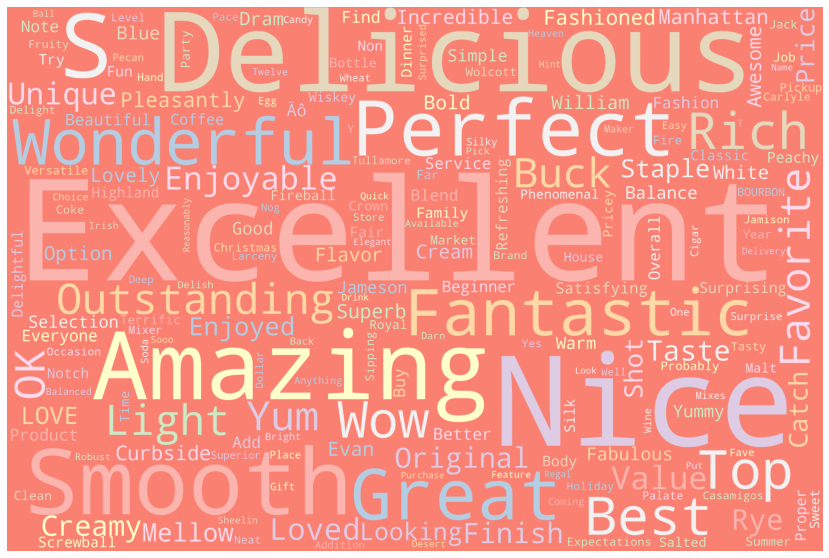

In [91]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud) 
    #plt.tight_layout(pad=0)
    plt.axis("off");
    
plot_cloud(wordcloud)

### Negative reviews:

In [51]:
#string = df[df['Final_sentiment']<0]['Reviews_title'].dropna().to_list()
string = ' '.join(sn)

In [57]:
string=string.replace('Good','')
string=string.replace('Great','')
string=string.replace('Smooth','')
string=string.replace('Bottle','')

In [58]:
import nltk
from nltk.corpus import stopwords
stop_words = list(stopwords.words("english"))
STOPWORDS=stop_words

In [59]:
#STOPWORDS = nltk.corpus.stopwords.words('english')
STOPWORDS.extend(['Good','Great'])

In [60]:
%%time
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', 
                      collocations=False, stopwords = STOPWORDS).generate(string)

CPU times: user 11.6 s, sys: 2.26 s, total: 13.9 s
Wall time: 13.9 s


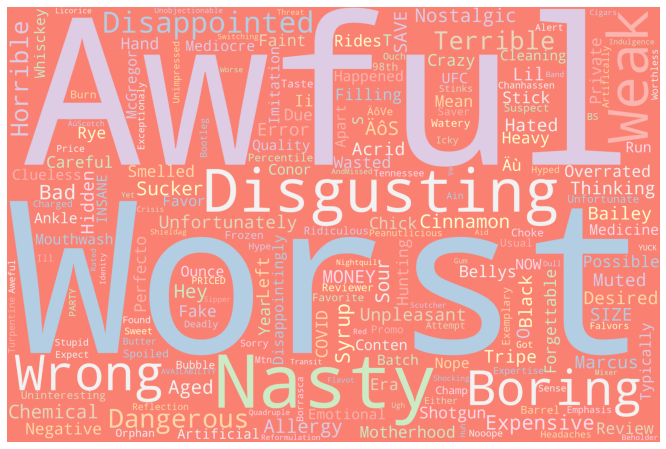

In [63]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(25, 8))
    plt.imshow(wordcloud) 
    #plt.tight_layout(pad=0)
    plt.axis("off");
    
plot_cloud(wordcloud)

### N-gram analysis

In [774]:
stop=list(stopwords.words('english'))
stop.extend(['The','the','In','also','fig','Figure','et','al.,','al', 'figure','also', 'et '])

In [775]:
def initial_clean(text):
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text


def remove_stop_words(text):
    return [word for word in text if word not in stop]

lemmatizer = WordNetLemmatizer()
def stem_words(text):
    try:
        text = [lemmatizer.lemmatize(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    if type(text) is not float:
        return ' '.join(remove_stop_words(initial_clean(text)))
    else:
        return text

In [776]:
from tqdm import tqdm
tqdm.pandas(desc="my bar!")
#df_ngram=df.dropna(subset=['Reviews'])
k = df['Reviews'].apply(apply_all)
df['TEXT'] = k

In [777]:
def create_corpus(data):
    corpus=[]
    
    for x in data['TEXT'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [779]:
corpus=create_corpus(df.dropna(subset=['Reviews']))

In [472]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(4, 4)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [485]:
top_bigrams=get_top_bigrams(df[df['Review_sentiment']<0]['TEXT'])[:5]

<AxesSubplot:>

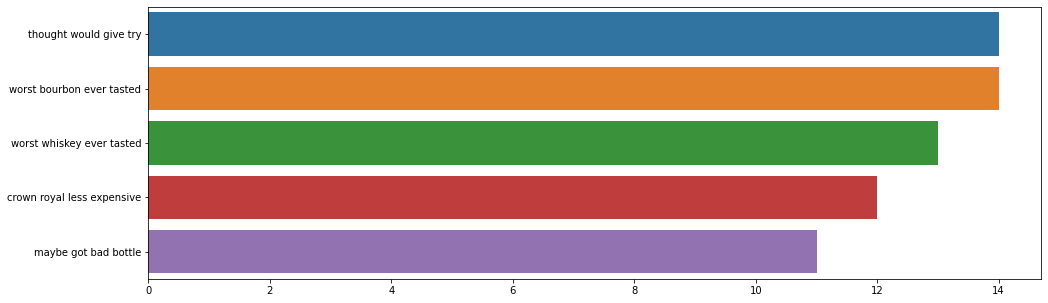

In [486]:
plt.figure(figsize=(16,5))
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)